In [9]:
## Load modules

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, savgol_filter

## Rendija sencilla 1

Recortar la imagen a una región rectangular. Foto 1


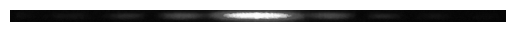

In [3]:
# Cargar la imagen
image_path = "Rejilla_sencilla_1-1.jpg"
img = Image.open(image_path).convert('L')  # Escala de grises
img_array = np.array(img)

# Calcular un umbral para identificar la luz
threshold = np.percentile(img_array, 95)  # 5% más brillante
binary_mask = img_array > threshold

# Centro de masa (principalmente en y)
com_y, _ = center_of_mass(binary_mask)

# Definir altura del recorte
h = 50  # puedes ajustar esta altura (en píxeles)
half_h = h // 2

# Coordenadas del recorte
x_min = 0
x_max = img.width
y_min = max(0, int(com_y) - half_h)
y_max = min(img.height, int(com_y) + half_h)

# Recortar
cropped_img_1 = img.crop((x_min, y_min, x_max, y_max))

# Mostrar resultado
plt.imshow(cropped_img_1, cmap='gray')

plt.axis('off')
plt.show()

Centro en píxel: 1024
Primer pico en píxel: 1327
cm/píxel: 0.01313


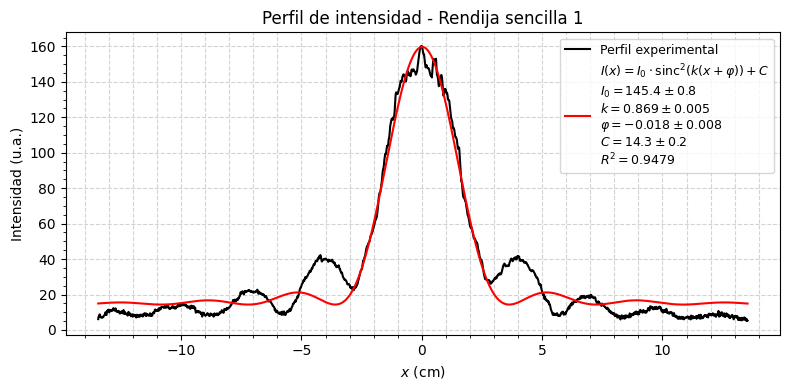

In [4]:
# === Medir intensidad en x ===
cropped_array_1 = np.array(cropped_img_1)

# ===  Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_1, axis=0)
x_pixels = np.arange(len(intensity_profile))

# === Encontrar máximo central y primer pico ===

# Encontrar máximo global (centro del patrón)
x_centro_px = np.argmax(intensity_profile)

# Para encontrar el primer pico a la derecha:
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=180)

# Filtrar picos a la derecha del centro
peaks_right = peaks[peaks > x_centro_px]
if len(peaks_right) == 0:
    raise ValueError("No se encontró un pico a la derecha del centro.")

x_pico_px = peaks_right[0]

# Factor de conversión
dist_cm = 3.978  # calibración. es la distancia al primer maximo del patrón de difracción (tracker)
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px

# Vector de posiciones en cm centrado en 0
x_cm = (x_pixels - x_centro_px) * cm_per_px

print(f"Centro en píxel: {x_centro_px}")
print(f"Primer pico en píxel: {x_pico_px}")
print(f"cm/píxel: {cm_per_px:.5f}")

# === Ajuste sinc² ===

def sinc2(x, I0, k_1, phi, offset):
    z = k_1*(x + phi)
    # sinc(z) = sin(z)/z, definimos sinc(0)=1
    sinc_z = np.ones_like(z)
    mask = z != 0
    sinc_z[mask] = np.sin(z[mask]) / z[mask]
    return I0 * sinc_z**2 + offset

p0 = [np.max(intensity_profile) - np.min(intensity_profile), np.pi/3, 0, np.min(intensity_profile)]
popt, pcov = curve_fit(sinc2, x_cm, intensity_profile, p0=p0, maxfev=10000)
perr = np.sqrt(np.diag(pcov))

I0, k_1, phi, offset = popt
dI0, dk, dphi, doffset = perr

# === R^2 ===
y_fit = sinc2(x_cm, *popt)
residuals = intensity_profile - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((intensity_profile - np.mean(intensity_profile))**2)
r_squared = 1 - (ss_res / ss_tot)

# === Graficar ===
x_fit = np.linspace(x_cm.min(), x_cm.max(), 1000)
y_fit_smooth = sinc2(x_fit, *popt)

eq_label = (
    r"$I(x) = I_0 \cdot \text{sinc}^2(k(x+\varphi)) + C$" + "\n"
    + rf"$I_0 = {I0:.1f} \pm {dI0:.1f}$" + "\n"
    + rf"$k = {k_1:.3f} \pm {dk:.3f}$" + "\n"
    + rf"$\varphi = {phi:.3f} \pm {dphi:.3f}$" + "\n"
    + rf"$C = {offset:.1f} \pm {doffset:.1f}$" + "\n"
    + rf"$R^2 = {r_squared:.4f}$"
)



plt.figure(figsize=(8,4))
plt.plot(x_cm, intensity_profile, label='Perfil experimental',color='black')
plt.plot(x_fit, y_fit_smooth, '-', color='red', label= eq_label)
plt.xlabel("$x$ (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad - Rendija sencilla 1")
# Activar ticks secundarios en el eje X
plt.minorticks_on()
plt.legend(loc='upper right', fontsize=9)
plt.grid(axis='x', which='both', linestyle='--',color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--',color='lightgrey')
plt.tight_layout()
plt.show()

Centro en píxel: 1024
Primer pico en píxel: 1327
cm/píxel: 0.01313
Rango local: -3.44 cm a 3.44 cm


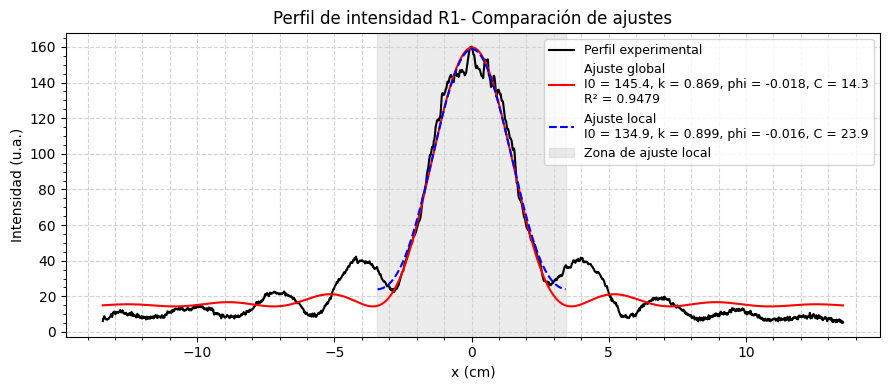

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter

# === Medir intensidad en x ===
cropped_array_1 = np.array(cropped_img_1)

# === Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_1, axis=0)
x_pixels = np.arange(len(intensity_profile))
x_centro_px = np.argmax(intensity_profile)

# === Suavizar para detectar mínimos ===
smooth_profile = savgol_filter(intensity_profile, window_length=51, polyorder=3)

# Buscar mínimos: invertir perfil y buscar picos (mínimos)
inverted = -smooth_profile
minimos_idx, _ = find_peaks(inverted, distance=80)

# Filtrar mínimos antes y después del centro
minimos_izq = minimos_idx[minimos_idx < x_centro_px]
minimos_der = minimos_idx[minimos_idx > x_centro_px]
if len(minimos_izq) == 0 or len(minimos_der) == 0:
    raise ValueError("No se encontraron mínimos suficientes para definir la zona de ajuste local.")
x_min_px = minimos_izq[-3]
x_max_px = minimos_der[2]

# === Primer pico para calibración ===
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=180)
peaks_right = peaks[peaks > x_centro_px]
x_pico_px = peaks_right[0] if len(peaks_right) > 0 else x_centro_px + 200

# === Escala en cm ===
dist_cm = 3.978  # calibración
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px
x_cm = (x_pixels - x_centro_px) * cm_per_px
x_min = -2.938613861386139-0.5
x_max = 2.938613861386139+0.5

print(f"Centro en píxel: {x_centro_px}")
print(f"Primer pico en píxel: {x_pico_px}")
print(f"cm/píxel: {cm_per_px:.5f}")
print(f"Rango local: {x_min:.2f} cm a {x_max:.2f} cm")

# === Modelo sinc² ===
def sinc2(x, I0, k_1, phi, offset):
    z = k_1 * (x + phi)
    sinc_z = np.ones_like(z)
    mask = z != 0
    sinc_z[mask] = np.sin(z[mask]) / z[mask]
    return I0 * sinc_z**2 + offset

p0 = [np.max(intensity_profile) - np.min(intensity_profile), np.pi/3, 0, np.min(intensity_profile)]

# === Ajuste global ===
popt_all, pcov_all = curve_fit(sinc2, x_cm, intensity_profile, p0=p0, maxfev=10000)
I0_all, k_all, phi_all, offset_all = popt_all
perr_all = np.sqrt(np.diag(pcov_all))
y_fit_all = sinc2(x_cm, *popt_all)
r2_all = 1 - np.sum((intensity_profile - y_fit_all)**2) / np.sum((intensity_profile - np.mean(intensity_profile))**2)

# === Ajuste local ===
mask_local = (x_cm >= x_min) & (x_cm <= x_max)
x_local = x_cm[mask_local]
intensity_local = intensity_profile[mask_local]
popt_local, pcov_local = curve_fit(sinc2, x_local, intensity_local, p0=p0, maxfev=10000)
I0_loc, k_loc, phi_loc, offset_loc = popt_local
perr_local = np.sqrt(np.diag(pcov_local))
x_fit_local = np.linspace(x_local.min(), x_local.max(), 500)
y_fit_local = sinc2(x_fit_local, *popt_local)

# === Graficar ===
x_fit_all = np.linspace(x_cm.min(), x_cm.max(), 1000)
y_fit_all_smooth = sinc2(x_fit_all, *popt_all)

label_global = (
    "Ajuste global\n"
    + f"I0 = {I0_all:.1f}, k = {k_all:.3f}, phi = {phi_all:.3f}, C = {offset_all:.1f}\n"
    + f"R² = {r2_all:.4f}"
)

label_local = (
    "Ajuste local\n"
    + f"I0 = {I0_loc:.1f}, k = {k_loc:.3f}, phi = {phi_loc:.3f}, C = {offset_loc:.1f}"
)

plt.figure(figsize=(9, 4))
plt.plot(x_cm, intensity_profile, label="Perfil experimental", color='black')
plt.plot(x_fit_all, y_fit_all_smooth, '-', color='red', label=label_global)
plt.plot(x_fit_local, y_fit_local, '--', color='blue', label=label_local)
plt.axvspan(x_min, x_max, color='gray', alpha=0.15, label='Zona de ajuste local')
plt.xlabel("x (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad R1- Comparación de ajustes")
plt.legend(fontsize=9, loc='upper right')
plt.minorticks_on()
plt.grid(axis='x', which='both', linestyle='--', color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--', color='lightgrey')
plt.tight_layout()
plt.show()


In [6]:
print(x_min)
print(x_centro_px)
print(x_centro_px - x_min_px)

-3.438613861386139
1024
300


cálculos (depronto hay algo mal xd)

In [7]:
#ancho de la rejilla (w)
#Ajuste
z = 482.3 #cm +- 1cm
lam = 650e-7 #cm (longitud de onda del laser rojo)
print(k_1)

w_ajust_all = (z*lam*k_all/np.pi)*10 #mm
w_ajust_loc = (z*lam*k_loc/np.pi)*10
print("Global: ",w_ajust_all, ". Error %: ",(w_ajust_all-0.11)*100/0.11)
print("Local: ",w_ajust_loc, ". Error %: ",(w_ajust_loc-0.11)*100/0.11)

#Tracker
x_m = 2.77 #cm +- 0.001 cm(primer cero de irradiancia)
w_trac = (lam*z/2*x_m)*10 #mm
print(w_trac)



0.8689026895134719
Global:  0.08670654622831743 . Error %:  -21.175867065165974
Local:  0.08975529920662488 . Error %:  -18.404273448522837
0.43419057499999997


## Rejilla sencilla 2

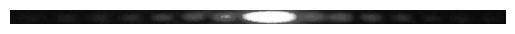

In [8]:
# Cargar la imagen
image_path = "Rejilla_sencilla_2-1.jpg"
img = Image.open(image_path).convert('L')  # Escala de grises
img_array = np.array(img)

# Calcular un umbral para identificar la luz
threshold = np.percentile(img_array, 95)  # 5% más brillante
binary_mask = img_array > threshold

# Centro de masa (principalmente en y)
com_y, _ = center_of_mass(binary_mask)

# Definir altura del recorte
h = 50  # puedes ajustar esta altura (en píxeles)
half_h = h // 2

# Coordenadas del recorte
x_min = 0
x_max = img.width
y_min = max(0, int(com_y) - half_h)
y_max = min(img.height, int(com_y) + half_h)

# Recortar
cropped_img_2 = img.crop((x_min, y_min, x_max, y_max))

# Mostrar resultado
plt.imshow(cropped_img_2, cmap='gray')

plt.axis('off')
plt.show()

Centro en píxel: 919
Primer pico en píxel: 1064
cm/píxel: 0.01434


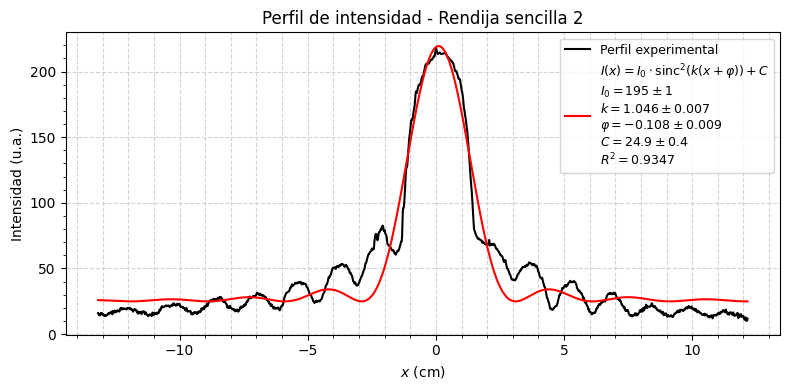

In [9]:
# === Medir intensidad en x ===
cropped_array_2 = np.array(cropped_img_2)

# ===  Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_2, axis=0)
x_pixels = np.arange(len(intensity_profile))

# === Encontrar máximo central y primer pico ===

# Encontrar máximo global (centro del patrón)
x_centro_px = np.argmax(intensity_profile)

# Para encontrar el primer pico a la derecha:
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=130)

# Filtrar picos a la derecha del centro
peaks_right = peaks[peaks > x_centro_px]
if len(peaks_right) == 0:
    raise ValueError("No se encontró un pico a la derecha del centro.")

x_pico_px = peaks_right[0]

# Factor de conversión
dist_cm = 2.079  # calibración
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px

# Vector de posiciones en cm centrado en 0
x_cm = (x_pixels - x_centro_px) * cm_per_px

print(f"Centro en píxel: {x_centro_px}")
print(f"Primer pico en píxel: {x_pico_px}")
print(f"cm/píxel: {cm_per_px:.5f}")

# === Ajuste sinc² ===

def sinc2(x, I0, k_2, phi, offset):
    z = k_2*(x + phi)
    # sinc(z) = sin(z)/z, definimos sinc(0)=1
    sinc_z = np.ones_like(z)
    mask = z != 0
    sinc_z[mask] = np.sin(z[mask]) / z[mask]
    return I0 * sinc_z**2 + offset

p0 = [np.max(intensity_profile) - np.min(intensity_profile), np.pi/3, 0, np.min(intensity_profile)]
popt, pcov = curve_fit(sinc2, x_cm, intensity_profile, p0=p0, maxfev=10000)
perr = np.sqrt(np.diag(pcov))

I0, k_2, phi, offset = popt
dI0, dk, dphi, doffset = perr

# === R^2 ===
y_fit = sinc2(x_cm, *popt)
residuals = intensity_profile - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((intensity_profile - np.mean(intensity_profile))**2)
r_squared = 1 - (ss_res / ss_tot)

# === Graficar ===
x_fit = np.linspace(x_cm.min(), x_cm.max(), 1000)
y_fit_smooth = sinc2(x_fit, *popt)

eq_label = (
    r"$I(x) = I_0 \cdot \text{sinc}^2(k(x+\varphi)) + C$" + "\n"
    + rf"$I_0 = {I0:.0f} \pm {dI0:.0f}$" + "\n"
    + rf"$k = {k_2:.3f} \pm {dk:.3f}$" + "\n"
    + rf"$\varphi = {phi:.3f} \pm {dphi:.3f}$" + "\n"
    + rf"$C = {offset:.1f} \pm {doffset:.1f}$" + "\n"
    + rf"$R^2 = {r_squared:.4f}$"
)



plt.figure(figsize=(8,4))
plt.plot(x_cm, intensity_profile, label='Perfil experimental',color='black')
plt.plot(x_fit, y_fit_smooth, '-', color='red', label= eq_label)
plt.xlabel("$x$ (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad - Rendija sencilla 2")
# Activar ticks secundarios en el eje X
plt.minorticks_on()
plt.legend(loc='upper right', fontsize=9)
plt.grid(axis='x', which='both', linestyle='--',color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--',color='lightgrey')
plt.tight_layout()
plt.show()

Centro en píxel: 919
Primer pico en píxel: 1108
cm/píxel: 0.01100
Rango local: -2.00 cm a 2.00 cm


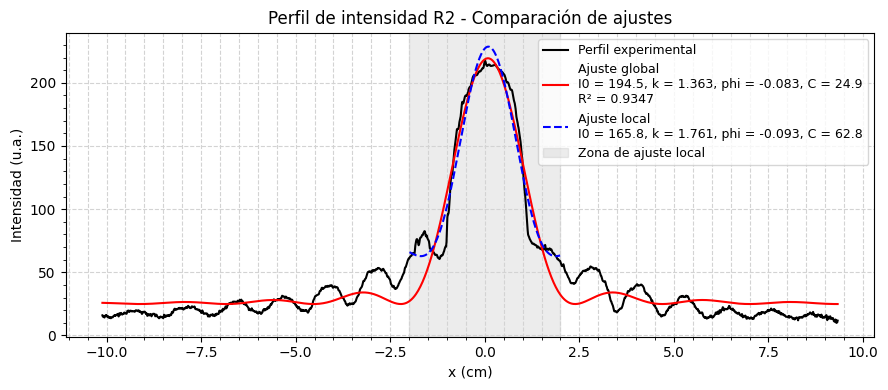

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter

# === Medir intensidad en x ===
cropped_array_2 = np.array(cropped_img_2)

# === Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_2, axis=0)
x_pixels = np.arange(len(intensity_profile))
x_centro_px = np.argmax(intensity_profile)

# === Suavizar para detectar mínimos ===
smooth_profile = savgol_filter(intensity_profile, window_length=51, polyorder=3)

# Buscar mínimos: invertir perfil y buscar picos (mínimos)
inverted = -smooth_profile
minimos_idx, _ = find_peaks(inverted, distance=80)

# Filtrar mínimos antes y después del centro
minimos_izq = minimos_idx[minimos_idx < x_centro_px]
minimos_der = minimos_idx[minimos_idx > x_centro_px]
if len(minimos_izq) == 0 or len(minimos_der) == 0:
    raise ValueError("No se encontraron mínimos suficientes para definir la zona de ajuste local.")
x_min_px = minimos_izq[-3]
x_max_px = minimos_der[2]

# === Primer pico para calibración ===
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=180)
peaks_right = peaks[peaks > x_centro_px]
x_pico_px = peaks_right[0] if len(peaks_right) > 0 else x_centro_px + 200

# === Escala en cm ===
dist_cm = 2.079  # calibración
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px
x_cm = (x_pixels - x_centro_px) * cm_per_px
x_min = -2.0
x_max = 2.0

print(f"Centro en píxel: {x_centro_px}")
print(f"Primer pico en píxel: {x_pico_px}")
print(f"cm/píxel: {cm_per_px:.5f}")
print(f"Rango local: {x_min:.2f} cm a {x_max:.2f} cm")

# === Modelo sinc² ===
def sinc2(x, I0, k_1, phi, offset):
    z = k_1 * (x + phi)
    sinc_z = np.ones_like(z)
    mask = z != 0
    sinc_z[mask] = np.sin(z[mask]) / z[mask]
    return I0 * sinc_z**2 + offset

p0 = [np.max(intensity_profile) - np.min(intensity_profile), np.pi/3, 0, np.min(intensity_profile)]

# === Ajuste global ===
popt_all, pcov_all = curve_fit(sinc2, x_cm, intensity_profile, p0=p0, maxfev=10000)
I0_all, k2_all, phi2_all, offset2_all = popt_all
perr_all = np.sqrt(np.diag(pcov_all))
y_fit_all = sinc2(x_cm, *popt_all)
r2_all = 1 - np.sum((intensity_profile - y_fit_all)**2) / np.sum((intensity_profile - np.mean(intensity_profile))**2)

# === Ajuste local ===
mask_local = (x_cm >= x_min) & (x_cm <= x_max)
x_local = x_cm[mask_local]
intensity_local = intensity_profile[mask_local]
popt_local, pcov_local = curve_fit(sinc2, x_local, intensity_local, p0=p0, maxfev=10000)
I0_loc, k2_loc, phi2_loc, offset2_loc = popt_local
perr_local = np.sqrt(np.diag(pcov_local))
x_fit_local = np.linspace(x_local.min(), x_local.max(), 500)
y_fit_local = sinc2(x_fit_local, *popt_local)

# === Graficar ===
x_fit_all = np.linspace(x_cm.min(), x_cm.max(), 1000)
y_fit_all_smooth = sinc2(x_fit_all, *popt_all)

label_global = (
    "Ajuste global\n"
    + f"I0 = {I0_all:.1f}, k = {k2_all:.3f}, phi = {phi2_all:.3f}, C = {offset2_all:.1f}\n"
    + f"R² = {r2_all:.4f}"
)

label_local = (
    "Ajuste local\n"
    + f"I0 = {I0_loc:.1f}, k = {k2_loc:.3f}, phi = {phi2_loc:.3f}, C = {offset2_loc:.1f}"
)

plt.figure(figsize=(9, 4))
plt.plot(x_cm, intensity_profile, label="Perfil experimental", color='black')
plt.plot(x_fit_all, y_fit_all_smooth, '-', color='red', label=label_global)
plt.plot(x_fit_local, y_fit_local, '--', color='blue', label=label_local)
plt.axvspan(x_min, x_max, color='gray', alpha=0.15, label='Zona de ajuste local')
plt.xlabel("x (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad R2 - Comparación de ajustes")
plt.legend(fontsize=9, loc='upper right')
plt.minorticks_on()
plt.grid(axis='x', which='both', linestyle='--', color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--', color='lightgrey')
plt.tight_layout()
plt.show()


In [21]:
print(x_min)

-2.0


In [22]:
#ancho de la rejilla (w)
#Ajuste
z = 482.3 #cm +- 1cm
lam = 650e-7 #cm (longitud de onda del lasier rojo)


w2_ajust_all = (z*lam*k2_all/np.pi)*10 #mm
w2_ajust_loc = (z*lam*k2_loc/np.pi)*10
print("Global: ",w2_ajust_all, ". Error %: ",(w2_ajust_all-0.21)*100/0.21)
print("Local: ",w2_ajust_loc, ". Error %: ",(w2_ajust_loc-0.21)*100/0.21)


w_ajus = (z*lam*k_2/np.pi)*10 #mm
print("antigua ",w_ajus)

#Tracker
x_m = 1.494 #cm +- 0.001 cm(primer cero de irradiancia)
w_trac = (lam*z/2*x_m)*10 #mm
print(w_trac)







Global:  0.13598916214124282 . Error %:  -35.243256123217705
Local:  0.17577116705633086 . Error %:  -16.299444258890063
antigua  0.10433022689146289
0.23418076499999996


##Rendija sencilla 3


con esta se suavizó un poco en el centro de la franja central

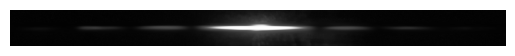

In [23]:


# Cargar la imagen
image_path = "Rejilla_sencilla_3-1.jpg"
img = Image.open(image_path).convert('L')  # Escala de grises
img_array = np.array(img)

# Detectar centro aproximado de la franja
threshold = np.percentile(img_array, 95)
binary_mask = img_array > threshold
com_y, _ = np.argwhere(binary_mask).mean(axis=0)
com_y = int(round(com_y))


# Crear copia modificada
img_modified_3 = img_array.copy()

# Definir rango vertical pequeño alrededor del centro
a = 5  # altura de la franja a suavizar
sigma = 15  # ancho del suavizado gaussiano (ajústalo según veas)

for dy in range(-h//2, h//2 + 1):
    y = com_y + dy
    if 0 <= y < img_array.shape[0]:
        fila_original = img_array[y, :]
        fila_suavizada = gaussian_filter1d(fila_original, sigma=sigma)
        img_modified_3[y, :] = fila_suavizada



# Definir altura del recorte
h = 50  # puedes ajustar esta altura (en píxeles)
half_h = h // 2

# Coordenadas del recorte
x_min = 0
x_max = img.width
y_min = max(0, int(com_y) - half_h)
y_max = min(img.height, int(com_y) + half_h)

# Recortar
cropped_img_3 = img.crop((x_min, y_min, x_max, y_max))

# Mostrar resultado
plt.imshow(img_modified_3, cmap='gray')

plt.axis('off')
plt.show()



Centro en píxel: 1120
Primer pico en píxel: 1455
cm/píxel: 0.02574


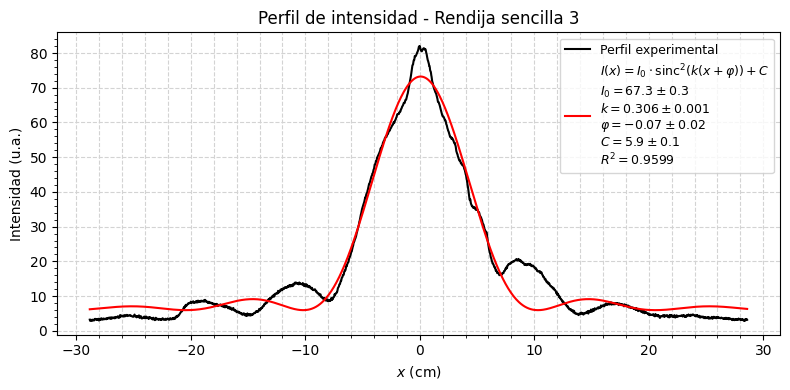

In [24]:
# === Medir intensidad en x ===
cropped_array_3 = np.array(img_modified_3)

# ===  Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_3, axis=0)
x_pixels = np.arange(len(intensity_profile))

# === Encontrar máximo central y primer pico ===

# Encontrar máximo global (centro del patrón)
x_centro_px = np.argmax(intensity_profile)

# Para encontrar el primer pico a la derecha:
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=250)

# Filtrar picos a la derecha del centro
peaks_right = peaks[peaks > x_centro_px]
if len(peaks_right) == 0:
    raise ValueError("No se encontró un pico a la derecha del centro.")

x_pico_px = peaks_right[0]

# Factor de conversión
dist_cm = 8.622  # calibración
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px

# Vector de posiciones en cm centrado en 0
x_cm = (x_pixels - x_centro_px) * cm_per_px

print(f"Centro en píxel: {x_centro_px}")
print(f"Primer pico en píxel: {x_pico_px}")
print(f"cm/píxel: {cm_per_px:.5f}")

# === Ajuste sinc² ===

def sinc2(x, I0, k, phi, offset):
    z = k*(x + phi)
    # sinc(z) = sin(z)/z, definimos sinc(0)=1
    sinc_z = np.ones_like(z)
    mask = z != 0
    sinc_z[mask] = np.sin(z[mask]) / z[mask]
    return I0 * sinc_z**2 + offset

p0 = [np.max(intensity_profile) - np.min(intensity_profile), np.pi/3, 0, np.min(intensity_profile)]
popt, pcov = curve_fit(sinc2, x_cm, intensity_profile, p0=p0, maxfev=10000)
perr = np.sqrt(np.diag(pcov))

I0, k, phi, offset = popt
dI0, dk, dphi, doffset = perr

# === R^2 ===
y_fit = sinc2(x_cm, *popt)
residuals = intensity_profile - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((intensity_profile - np.mean(intensity_profile))**2)
r_squared = 1 - (ss_res / ss_tot)

# === Graficar ===
x_fit = np.linspace(x_cm.min(), x_cm.max(), 1000)
y_fit_smooth = sinc2(x_fit, *popt)

eq_label = (
    r"$I(x) = I_0 \cdot \text{sinc}^2(k(x+\varphi)) + C$" + "\n"
    + rf"$I_0 = {I0:.1f} \pm {dI0:.1f}$" + "\n"
    + rf"$k = {k:.3f} \pm {dk:.3f}$" + "\n"
    + rf"$\varphi = {phi:.2f} \pm {dphi:.2f}$" + "\n"
    + rf"$C = {offset:.1f} \pm {doffset:.1f}$" + "\n"
    + rf"$R^2 = {r_squared:.4f}$"
)



plt.figure(figsize=(8,4))
plt.plot(x_cm, intensity_profile, label='Perfil experimental',color='black')
plt.plot(x_fit, y_fit_smooth, '-', color='red', label= eq_label)
plt.xlabel("$x$ (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad - Rendija sencilla 3")
# Activar ticks secundarios en el eje X
plt.minorticks_on()
plt.legend(loc='upper right', fontsize=9)
plt.grid(axis='x', which='both', linestyle='--',color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--',color='lightgrey')
plt.tight_layout()
plt.show()

Centro en píxel: 1105
Primer pico en píxel: 1295
cm/píxel: 0.04538
Rango local: -13.00 cm a 13.00 cm


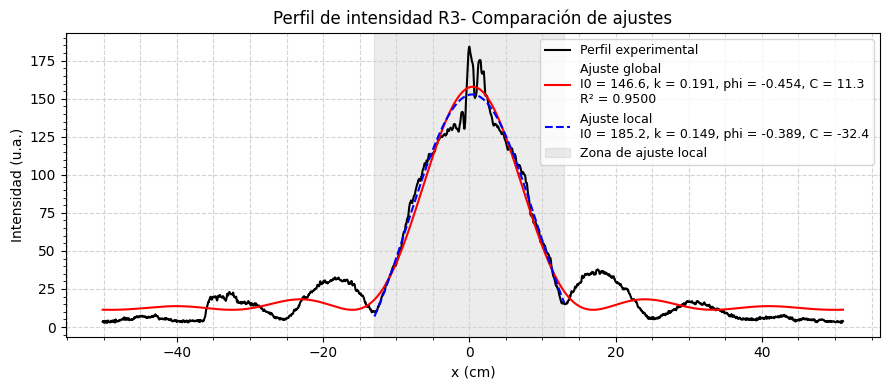

In [25]:
## 2 try

# === Medir intensidad en x ===
cropped_array_3 = np.array(cropped_img_3)

# === Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_3, axis=0)
x_pixels = np.arange(len(intensity_profile))
x_centro_px = np.argmax(intensity_profile)

# === Suavizar para detectar mínimos ===
smooth_profile = savgol_filter(intensity_profile, window_length=51, polyorder=3)

# Buscar mínimos: invertir perfil y buscar picos (mínimos)
inverted = -smooth_profile
minimos_idx, _ = find_peaks(inverted, distance=80)

# Filtrar mínimos antes y después del centro
minimos_izq = minimos_idx[minimos_idx < x_centro_px]
minimos_der = minimos_idx[minimos_idx > x_centro_px]
if len(minimos_izq) == 0 or len(minimos_der) == 0:
    raise ValueError("No se encontraron mínimos suficientes para definir la zona de ajuste local.")
x_min_px = minimos_izq[-3]
x_max_px = minimos_der[2]

# === Primer pico para calibración ===
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=180)
peaks_right = peaks[peaks > x_centro_px]
x_pico_px = peaks_right[0] if len(peaks_right) > 0 else x_centro_px + 200

# === Escala en cm ===
dist_cm = 8.622  # calibración
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px
x_cm = (x_pixels - x_centro_px) * cm_per_px
x_min = -13
x_max = 13
print(f"Centro en píxel: {x_centro_px}")
print(f"Primer pico en píxel: {x_pico_px}")
print(f"cm/píxel: {cm_per_px:.5f}")
print(f"Rango local: {x_min:.2f} cm a {x_max:.2f} cm")

# === Modelo sinc² ===
def sinc2(x, I0, k_1, phi, offset):
    z = k_1 * (x + phi)
    sinc_z = np.ones_like(z)
    mask = z != 0
    sinc_z[mask] = np.sin(z[mask]) / z[mask]
    return I0 * sinc_z**2 + offset

p0 = [np.max(intensity_profile) - np.min(intensity_profile), np.pi/3, 0, np.min(intensity_profile)]

# === Ajuste global ===
popt_all, pcov_all = curve_fit(sinc2, x_cm, intensity_profile, p0=p0, maxfev=10000)
I0_all, k3_all, phi3_all, offset3_all = popt_all
perr_all = np.sqrt(np.diag(pcov_all))
y_fit_all = sinc2(x_cm, *popt_all)
r2_all = 1 - np.sum((intensity_profile - y_fit_all)**2) / np.sum((intensity_profile - np.mean(intensity_profile))**2)

# === Ajuste local ===
mask_local = (x_cm >= x_min) & (x_cm <= x_max)
x_local = x_cm[mask_local]
intensity_local = intensity_profile[mask_local]
popt_local, pcov_local = curve_fit(sinc2, x_local, intensity_local, p0=p0, maxfev=10000)
I0_loc, k3_loc, phi3_loc, offset3_loc = popt_local
perr_local = np.sqrt(np.diag(pcov_local))
x_fit_local = np.linspace(x_local.min(), x_local.max(), 500)
y_fit_local = sinc2(x_fit_local, *popt_local)

# === Graficar ===
x_fit_all = np.linspace(x_cm.min(), x_cm.max(), 1000)
y_fit_all_smooth = sinc2(x_fit_all, *popt_all)

label_global = (
    "Ajuste global\n"
    + f"I0 = {I0_all:.1f}, k = {k3_all:.3f}, phi = {phi3_all:.3f}, C = {offset3_all:.1f}\n"
    + f"R² = {r2_all:.4f}"
)

label_local = (
    "Ajuste local\n"
    + f"I0 = {I0_loc:.1f}, k = {k3_loc:.3f}, phi = {phi3_loc:.3f}, C = {offset3_loc:.1f}"
)

plt.figure(figsize=(9, 4))
plt.plot(x_cm, intensity_profile, label="Perfil experimental", color='black')
plt.plot(x_fit_all, y_fit_all_smooth, '-', color='red', label=label_global)
plt.plot(x_fit_local, y_fit_local, '--', color='blue', label=label_local)
plt.axvspan(x_min, x_max, color='gray', alpha=0.15, label='Zona de ajuste local')
plt.xlabel("x (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad R3- Comparación de ajustes")
plt.legend(fontsize=9, loc='upper right')
plt.minorticks_on()
plt.grid(axis='x', which='both', linestyle='--', color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--', color='lightgrey')
plt.tight_layout()
plt.show()


In [26]:
#ancho de la rejilla (w)
#Ajuste
z = 482.3 #cm +- 1cm
lam = 650e-7 #cm (longitud de onda del lasier rojo)

w3_ajust_all = (z*lam*k3_all/np.pi)*10 #mm
w3_ajust_loc = (z*lam*k3_loc/np.pi)*10
print("Global: ",w3_ajust_all, ". Error %: ",(w3_ajust_all-0.013)*100/0.013)
print("Local: ",w3_ajust_loc, ". Error %: ",(w3_ajust_loc-0.013)*100/0.013)

w_ajus = (z*lam*k/np.pi)*10 #mm
print("antiguo", w_ajus)

#Tracker
x_m = 6.199 #cm +- 0.001 cm(primer cero de irradiancia)
w_trac = (lam*z/2*x_m)*10 #mm
print(w_trac)

Global:  0.01903215149256232 . Error %:  46.40116532740248
Local:  0.014826872761848667 . Error %:  14.052867398835906
antiguo 0.03057552678306405
0.9716777524999998


##Rendija doble 1

In [6]:
# Cargar la imagen
image_path = "Rejilla_doble_1-1.jpg"
img = Image.open(image_path).convert('L')  # Escala de grises
img_array = np.array(img)

# Calcular un umbral para identificar la luz
threshold = np.percentile(img_array, 95)  # 5% más brillante
binary_mask = img_array > threshold

# Centro de masa (principalmente en y)
com_y, _ = center_of_mass(binary_mask)

# Definir altura del recorte
h = 50  # puedes ajustar esta altura (en píxeles)
half_h = h // 2

# Coordenadas del recorte
x_min = 0
x_max = img.width
y_min = max(0, int(com_y) - half_h)
y_max = min(img.height, int(com_y) + half_h)

# Recortar
cropped_img_4 = img.crop((x_min, y_min, x_max, y_max))

# Mostrar resultado
plt.imshow(cropped_img_4, cmap='gray')

plt.axis('off')
plt.show()

Centro en píxel: 1158
Primer pico en píxel: 1481
cm/píxel: 0.01282


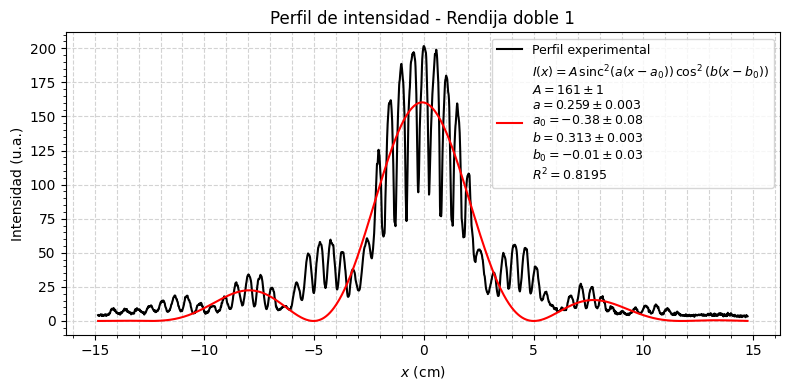

In [15]:
# === Medir intensidad en x ===
cropped_array_4 = np.array(cropped_img_4)

# ===  Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_4, axis=0)
x_pixels = np.arange(len(intensity_profile))

# === Encontrar máximo central y primer pico ===

# Encontrar máximo global (centro del patrón)
x_centro_px = np.argmax(intensity_profile)

# Para encontrar el primer pico a la derecha:
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=170)

# Filtrar picos a la derecha del centro
peaks_right = peaks[peaks > x_centro_px]
if len(peaks_right) == 0:
    raise ValueError("No se encontró un pico a la derecha del centro.")

x_pico_px = peaks_right[0]

# Factor de conversión
dist_cm = 4.14  # calibración
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px

# Vector de posiciones en cm centrado en 0
x_cm = (x_pixels - x_centro_px) * cm_per_px

print(f"Centro en píxel: {x_centro_px}")
print(f"Primer pico en píxel: {x_pico_px}")
print(f"cm/píxel: {cm_per_px:.5f}")

#x_cm
#intensity_profile

# Definir la función modelo
def double_slit(x, A, a, a0, b, b0):
    #sinc_term = np.sinc(a * (x - a0))  # np.sinc(x) = sin(pi x)/(pi x)
    sinc_term = np.sinc((a * (x - a0)) / np.pi) #corrección
    cos_term = np.cos(b * (x - b0))
    return A * sinc_term**2 * cos_term**2

# Estimación inicial de parámetros (ajústalos si conviene)
p0 = [np.max(intensity_profile), 1.0, 0.0, 1.0, 0.0]

# Ajuste de curva
popt, pcov = curve_fit(double_slit, x_cm, intensity_profile, p0=p0,maxfev=20000)
perr = np.sqrt(np.diag(pcov))

# Parámetros ajustados
A, a, a0, b, b0 = popt
dA, da, da0, db, db0 = perr

# Calcular R²
I_fit = double_slit(x_cm, *popt)
residuals = intensity_profile - I_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((intensity_profile - np.mean(intensity_profile))**2)
r_squared = 1 - (ss_res / ss_tot)

# Datos para la curva ajustada
x_fit = np.linspace(np.min(x_cm), np.max(x_cm), 1000)
I_fit_curve = double_slit(x_fit, *popt)

# Etiqueta con los parámetros
eq_label = (
    r"$I(x) = A\, \mathrm{sinc}^2(a(x-a_0))\, \cos^2(b(x-b_0))$" + "\n"
    + rf"$A = {A:.0f} \pm {dA:.0f}$" + "\n"
    + rf"$a = {a:.3f} \pm {da:.3f}$" + "\n"
    + rf"$a_0 = {a0:.2f} \pm {da0:.2f}$" + "\n"
    + rf"$b = {b:.3f} \pm {db:.3f}$" + "\n"
    + rf"$b_0 = {b0:.2f} \pm {db0:.2f}$" + "\n"
    + rf"$R^2 = {r_squared:.4f}$"
)

# Gráfica


plt.figure(figsize=(8,4))
plt.plot(x_cm, intensity_profile, label='Perfil experimental',color='black')
plt.plot(x_fit, I_fit_curve, '-', color='red', label=eq_label)
plt.xlabel("$x$ (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad - Rendija doble 1")
# Activar ticks secundarios en el eje X
plt.minorticks_on()
plt.legend(loc='upper right', fontsize=9)
plt.grid(axis='x', which='both', linestyle='--',color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--',color='lightgrey')
plt.tight_layout()
plt.show()

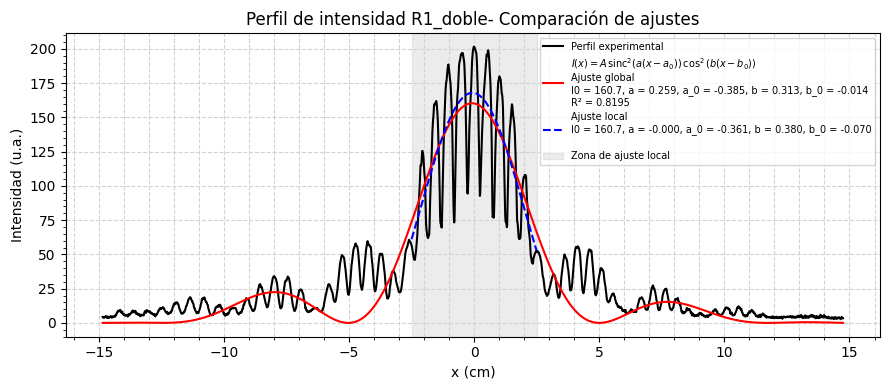

In [16]:
## 2 try

# === Medir intensidad en x ===
cropped_array_4 = np.array(cropped_img_4)

# === Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_4, axis=0)
x_pixels = np.arange(len(intensity_profile))
x_centro_px = np.argmax(intensity_profile)

# === Suavizar para detectar mínimos ===
smooth_profile = savgol_filter(intensity_profile, window_length=51, polyorder=3)

# Buscar mínimos: invertir perfil y buscar picos (mínimos)
inverted = -smooth_profile
minimos_idx, _ = find_peaks(inverted, distance=80)

# Filtrar mínimos antes y después del centro
minimos_izq = minimos_idx[minimos_idx < x_centro_px]
minimos_der = minimos_idx[minimos_idx > x_centro_px]
if len(minimos_izq) == 0 or len(minimos_der) == 0:
    raise ValueError("No se encontraron mínimos suficientes para definir la zona de ajuste local.")
x_min_px = minimos_izq[-3]
x_max_px = minimos_der[2]

# === Primer pico para calibración ===
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=180)
peaks_right = peaks[peaks > x_centro_px]
x_pico_px = peaks_right[0] if len(peaks_right) > 0 else x_centro_px + 200

# === Escala en cm ===
dist_cm = 4.14  # calibración
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px
x_cm = (x_pixels - x_centro_px) * cm_per_px
x_min = -2.5
x_max = 2.5

# Definir la función modelo
def double_slit(x, A, a, a0, b, b0):
    #sinc_term = np.sinc(a * (x - a0))  # np.sinc(x) = sin(pi x)/(pi x)
    sinc_term = np.sinc((a * (x - a0)) / np.pi) #corrección
    cos_term = np.cos(b * (x - b0))
    return A * sinc_term**2 * cos_term**2

# Estimación inicial de parámetros (ajústalos si conviene)
p0 = [np.max(intensity_profile), 1.0, 0.0, 1.0, 0.0]

# Parámetros ajustados
A, a, a0, b, b0 = popt
dA, da, da0, db, db0 = perr


# === Ajuste global ===
popt_all, pcov_all = curve_fit(double_slit, x_cm, intensity_profile, p0=p0, maxfev=10000)
I0_all, a1_all, a01_all, b1_all, b01_all = popt_all
perr_all = np.sqrt(np.diag(pcov_all))
y_fit_all = double_slit(x_cm, *popt_all)
r2_all = 1 - np.sum((intensity_profile - y_fit_all)**2) / np.sum((intensity_profile - np.mean(intensity_profile))**2)

# === Ajuste local ===
mask_local = (x_cm >= x_min) & (x_cm <= x_max)
x_local = x_cm[mask_local]
intensity_local = intensity_profile[mask_local]
popt_local, pcov_local = curve_fit(double_slit, x_local, intensity_local, p0=p0, maxfev=10000)
I0_loc, a1_loc, a01_loc, b1_loc, b01_loc = popt_local
#I0_loc, kds1_loc, phids1_loc, offsetds1_loc = popt_local
perr_local = np.sqrt(np.diag(pcov_local))
x_fit_local = np.linspace(x_local.min(), x_local.max(), 500)
y_fit_local = double_slit(x_fit_local, *popt_local)

# === Graficar ===
x_fit_all = np.linspace(x_cm.min(), x_cm.max(), 1000)
y_fit_all_smooth = double_slit(x_fit_all, *popt_all)

label_global = (
    r"$I(x) = A\, \mathrm{sinc}^2(a(x-a_0))\, \cos^2(b(x-b_0))$" + "\n" +
    "Ajuste global\n"
    + f"I0 = {I0_all:.1f}, a = {a1_all:.3f}, a_0 = {a01_all:.3f}, b = {b1_all:.3f}, b_0 = {b01_all:.3f}\n"
    + f"R² = {r2_all:.4f}"
)

label_local = (
    "Ajuste local\n"
    + f"I0 = {I0_all:.1f}, a = {a1_loc:.3f}, a_0 = {a01_loc:.3f}, b = {b1_loc:.3f}, b_0 = {b01_loc:.3f}\n"
    #+ f"I0 = {I0_loc:.1f}, k = {kds1_loc:.3f}, phi = {phids1_loc:.3f}, C = {offsetds1_loc:.1f}"
)





plt.figure(figsize=(9, 4))
plt.plot(x_cm, intensity_profile, label="Perfil experimental", color='black')
plt.plot(x_fit_all, y_fit_all_smooth, '-', color='red', label=label_global)
plt.plot(x_fit_local, y_fit_local, '--', color='blue', label=label_local)
plt.axvspan(x_min, x_max, color='gray', alpha=0.15, label='Zona de ajuste local')
plt.xlabel("x (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad R1_doble- Comparación de ajustes")
plt.legend(fontsize=7, loc='upper right')
plt.minorticks_on()
plt.grid(axis='x', which='both', linestyle='--', color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--', color='lightgrey')
plt.tight_layout()
plt.show()


aqui nuevamente puede que haya errores

In [17]:
#ancho de la rendija (w) y separacion entre las rendijas
#Ajuste
z = 482.3 #cm +- 1cm
lam = 650e-7 #cm (longitud de onda del lasier rojo)

#ancho
w1_x_ajust_all = (z*lam*a1_all/np.pi)*10 #mm
w1_x_ajust_loc = (z*lam*a1_loc/np.pi)*10
print("Ancho")
print("Global: ",w1_x_ajust_all, ". Error %: ",(w1_x_ajust_all-0.13)*100/0.13)
print("Local: ", w1_x_ajust_loc, ". Error %: ",(w1_x_ajust_loc-0.13)*100/0.13)

#separacion
d1_ajust_all = (z*lam*b1_all/np.pi)*10 #mm
d1_ajust_loc = (z*lam*b1_loc/np.pi)*10
print("Separacion")
print("Global: ",d1_ajust_all, ". Error %: ",(d1_ajust_all-0.62)*100/0.62)
print("Local: ", d1_ajust_loc, ". Error %: ",(d1_ajust_loc-0.62)*100/0.62)

#### Viejas
w_x_ajus = (z*lam*a/np.pi)*10 #mm
d_ajus = (z*lam*b/np.pi)*10

print("antiguo w_x_ajus =",w_x_ajus)
print("antiguo d_ajus =",d_ajus)


#Tracker
x_m = 3.1 #cm +- 0.001 cm(primer cero de irradiancia del patron de difracción)
x_n = 0.6 #cm +- 0.1 cm(separacion entre picos patron de interferencia)


w_x_trac = (lam*z/x_m)*10 #mm
d_trac = (lam*z/x_n)*10

print("w_x_trac =",w_x_trac)

print("d_trac =",d_trac)

Ancho
Global:  0.025849286798502374 . Error %:  -80.11593323192126
Local:  -3.3315404763961804e-05 . Error %:  -100.02562723443381
Separacion
Global:  0.031246535078987992 . Error %:  -94.96023627758258
Local:  0.037931908395634185 . Error %:  -93.88195025876867
antiguo w_x_ajus = 0.025849286798502374
antiguo d_ajus = 0.031246535078987992
w_x_trac = 0.10112741935483868
d_trac = 0.5224916666666666


##Rendija doble 2 (4)

In [3]:
# Cargar la imagen
image_path = "Rejilla_doble_4-1.jpg"
img = Image.open(image_path).convert('L')  # Escala de grises
img_array = np.array(img)

# Calcular un umbral para identificar la luz
threshold = np.percentile(img_array, 95)  # 5% más brillante
binary_mask = img_array > threshold

# Centro de masa (principalmente en y)
com_y, _ = center_of_mass(binary_mask)

# Definir altura del recorte
h = 60  # puedes ajustar esta altura (en píxeles)
half_h = h // 2

# Coordenadas del recorte
x_min = 0
x_max = img.width
y_min = max(0, int(com_y) - half_h)
y_max = min(img.height, int(com_y) + half_h)

# Recortar
cropped_img_5 = img.crop((x_min, y_min, x_max, y_max))

# Mostrar resultado
plt.imshow(cropped_img_5, cmap='gray')

plt.axis('off')
plt.show()

Centro en píxel: 1465
Primer pico en píxel: 1845
cm/píxel: 0.01405
ERROR! Session/line number was not unique in database. History logging moved to new session 2


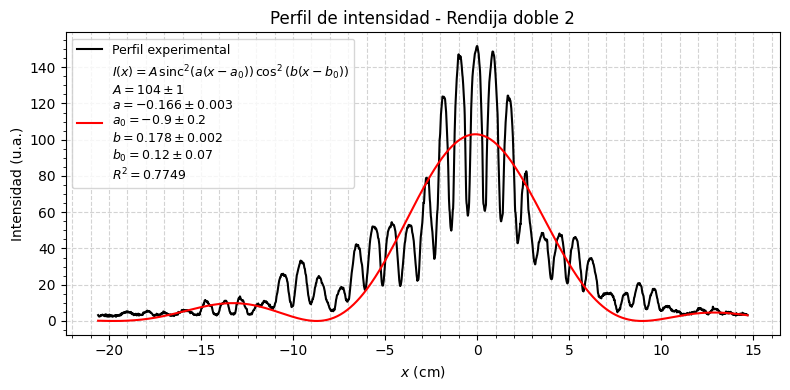

In [41]:
# === Medir intensidad en x ===
cropped_array_5 = np.array(cropped_img_5)

# ===  Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_5, axis=0)
x_pixels = np.arange(len(intensity_profile))

# === Encontrar máximo central y primer pico ===

# Encontrar máximo global (centro del patrón)
x_centro_px = np.argmax(intensity_profile)

# Para encontrar el primer pico a la derecha:
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=330)

# Filtrar picos a la derecha del centro
peaks_right = peaks[peaks > x_centro_px]
if len(peaks_right) == 0:
    raise ValueError("No se encontró un pico a la derecha del centro.")

x_pico_px = peaks_right[0]

# Factor de conversión
dist_cm = 5.34  # calibración
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px

# Vector de posiciones en cm centrado en 0
x_cm = (x_pixels - x_centro_px) * cm_per_px

print(f"Centro en píxel: {x_centro_px}")
print(f"Primer pico en píxel: {x_pico_px}")
print(f"cm/píxel: {cm_per_px:.5f}")

#x_cm
#intensity_profile

# Definir la función modelo
def double_slit(x, A, a, a0, b, b0):
    sinc_term = np.sinc(a * (x - a0) / np.pi)  # np.sinc(x) = sin(pi x)/(pi x)
    #sinc_term = np.sinc((a * (x - a0)) / np.pi) #corrección
    cos_term = np.cos(b * (x - b0))
    return A * sinc_term**2 * cos_term**2

# Estimación inicial de parámetros (ajústalos si conviene)
p0 = [np.max(intensity_profile), 1.0, 0.0, 1.0, 0.0]

# Ajuste de curva
popt, pcov = curve_fit(double_slit, x_cm, intensity_profile, p0=p0, maxfev=20000)
perr = np.sqrt(np.diag(pcov))

# Parámetros ajustados
A, a, a0, b, b0 = popt
dA, da, da0, db, db0 = perr

# Calcular R²
I_fit = double_slit(x_cm, *popt)
residuals = intensity_profile - I_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((intensity_profile - np.mean(intensity_profile))**2)
r_squared = 1 - (ss_res / ss_tot)

# Datos para la curva ajustada
x_fit = np.linspace(np.min(x_cm), np.max(x_cm), 1000)
I_fit_curve = double_slit(x_fit, *popt)

# Etiqueta con los parámetros
eq_label = (
    r"$I(x) = A\, \mathrm{sinc}^2(a(x-a_0))\, \cos^2(b(x-b_0))$" + "\n"
    + rf"$A = {A:.0f} \pm {dA:.0f}$" + "\n"
    + rf"$a = {a:.3f} \pm {da:.3f}$" + "\n"
    + rf"$a_0 = {a0:.1f} \pm {da0:.1f}$" + "\n"
    + rf"$b = {b:.3f} \pm {db:.3f}$" + "\n"
    + rf"$b_0 = {b0:.2f} \pm {db0:.2f}$" + "\n"
    + rf"$R^2 = {r_squared:.4f}$"
)

# Gráfica


plt.figure(figsize=(8,4))
plt.plot(x_cm, intensity_profile, label='Perfil experimental',color='black')
plt.plot(x_fit, I_fit_curve, '-', color='red', label=eq_label)
plt.xlabel("$x$ (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad - Rendija doble 2")
# Activar ticks secundarios en el eje X
plt.minorticks_on()
plt.legend(loc='upper left', fontsize=9)
plt.grid(axis='x', which='both', linestyle='--',color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--',color='lightgrey')
plt.tight_layout()
plt.show()

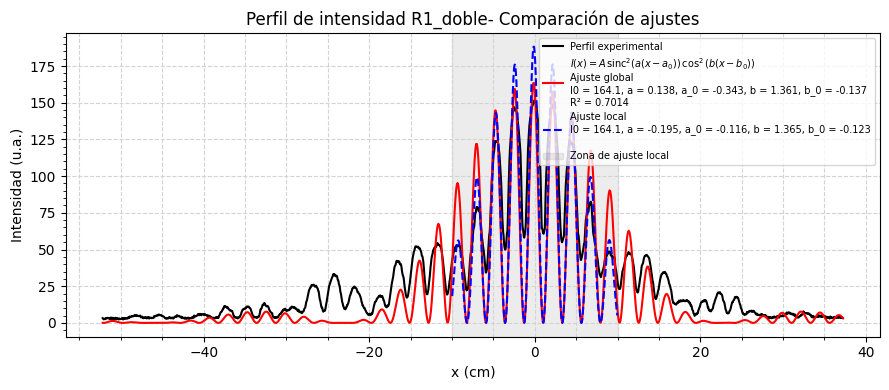

In [43]:
## 2 try

# === Medir intensidad en x ===
cropped_array_5 = np.array(cropped_img_5)

# === Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_5, axis=0)
x_pixels = np.arange(len(intensity_profile))
x_centro_px = np.argmax(intensity_profile)

# === Suavizar para detectar mínimos ===
smooth_profile = savgol_filter(intensity_profile, window_length=51, polyorder=3)

# Buscar mínimos: invertir perfil y buscar picos (mínimos)
inverted = -smooth_profile
minimos_idx, _ = find_peaks(inverted, distance=80)

# Filtrar mínimos antes y después del centro
minimos_izq = minimos_idx[minimos_idx < x_centro_px]
minimos_der = minimos_idx[minimos_idx > x_centro_px]
if len(minimos_izq) == 0 or len(minimos_der) == 0:
    raise ValueError("No se encontraron mínimos suficientes para definir la zona de ajuste local.")
x_min_px = minimos_izq[-3]
x_max_px = minimos_der[2]

# === Primer pico para calibración ===
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=180)
peaks_right = peaks[peaks > x_centro_px]
x_pico_px = peaks_right[0] if len(peaks_right) > 0 else x_centro_px + 200

# === Escala en cm ===
dist_cm = 6.77  # calibración
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px
x_cm = (x_pixels - x_centro_px) * cm_per_px
x_min = -10
x_max = 10

# Definir la función modelo
def double_slit(x, A, a, a0, b, b0):
    sinc_term = np.sinc(a * (x - a0) / np.pi)  # np.sinc(x) = sin(pi x)/(pi x)
    #sinc_term = np.sinc((a * (x - a0)) / np.pi) #corrección
    cos_term = np.cos(b * (x - b0))
    return A * sinc_term**2 * cos_term**2

# Estimación inicial de parámetros (ajústalos si conviene)
p0 = [np.max(intensity_profile), 1.0, 0.0, 1.0, 0.0]

# Parámetros ajustados
A, a, a0, b, b0 = popt
dA, da, da0, db, db0 = perr


# === Ajuste global ===
popt_all, pcov_all = curve_fit(double_slit, x_cm, intensity_profile, p0=p0, maxfev=20000)
I0_all, a2_all, a02_all, b2_all, b02_all = popt_all
perr_all = np.sqrt(np.diag(pcov_all))
y_fit_all = double_slit(x_cm, *popt_all)
r2_all = 1 - np.sum((intensity_profile - y_fit_all)**2) / np.sum((intensity_profile - np.mean(intensity_profile))**2)

# === Ajuste local ===
mask_local = (x_cm >= x_min) & (x_cm <= x_max)
x_local = x_cm[mask_local]
intensity_local = intensity_profile[mask_local]
popt_local, pcov_local = curve_fit(double_slit, x_local, intensity_local, p0=p0, maxfev=10000)
I0_loc, a2_loc, a02_loc, b2_loc, b02_loc = popt_local
#I0_loc, kds1_loc, phids1_loc, offsetds1_loc = popt_local
perr_local = np.sqrt(np.diag(pcov_local))
x_fit_local = np.linspace(x_local.min(), x_local.max(), 500)
y_fit_local = double_slit(x_fit_local, *popt_local)

# === Graficar ===
x_fit_all = np.linspace(x_cm.min(), x_cm.max(), 1000)
y_fit_all_smooth = double_slit(x_fit_all, *popt_all)

label_global = (
    r"$I(x) = A\, \mathrm{sinc}^2(a(x-a_0))\, \cos^2(b(x-b_0))$" + "\n" +
    "Ajuste global\n"
    + f"I0 = {I0_all:.1f}, a = {a2_all:.3f}, a_0 = {a02_all:.3f}, b = {b2_all:.3f}, b_0 = {b02_all:.3f}\n"
    + f"R² = {r2_all:.4f}"
)

label_local = (
    "Ajuste local\n"
    + f"I0 = {I0_all:.1f}, a = {a2_loc:.3f}, a_0 = {a02_loc:.3f}, b = {b2_loc:.3f}, b_0 = {b02_loc:.3f}\n"
    #+ f"I0 = {I0_loc:.1f}, k = {kds1_loc:.3f}, phi = {phids1_loc:.3f}, C = {offsetds1_loc:.1f}"
)





plt.figure(figsize=(9, 4))
plt.plot(x_cm, intensity_profile, label="Perfil experimental", color='black')
plt.plot(x_fit_all, y_fit_all_smooth, '-', color='red', label=label_global)
plt.plot(x_fit_local, y_fit_local, '--', color='blue', label=label_local)
plt.axvspan(x_min, x_max, color='gray', alpha=0.15, label='Zona de ajuste local')
plt.xlabel("x (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad R1_doble- Comparación de ajustes")
plt.legend(fontsize=7, loc='upper right')
plt.minorticks_on()
plt.grid(axis='x', which='both', linestyle='--', color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--', color='lightgrey')
plt.tight_layout()
plt.show()


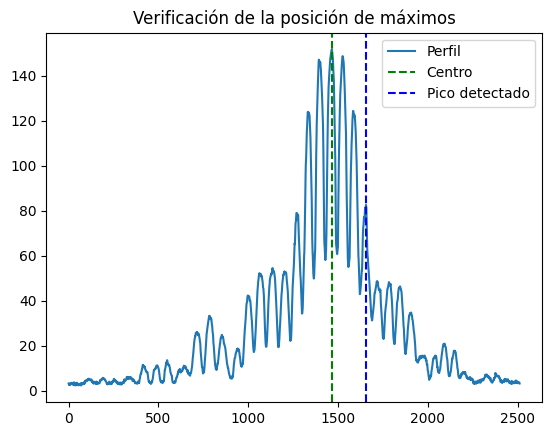

In [34]:
plt.plot(x_pixels, intensity_profile, label='Perfil')
plt.axvline(x_centro_px, color='green', linestyle='--', label='Centro')
plt.axvline(x_pico_px, color='blue', linestyle='--', label='Pico detectado')
plt.legend()
plt.title("Verificación de la posición de máximos")
plt.show()

In [31]:
#ancho de la rendija (w) y separacion entre las rendijas
#Ajuste
z = 482.3 #cm +- 1cm
lam = 650e-7 #cm (longitud de onda del lasier rojo)

#ancho
w1_x_ajust_all = (z*lam*a1_all/np.pi)*10 #mm
w1_x_ajust_loc = (z*lam*a1_loc/np.pi)*10
print("Ancho")
print("Global: ",w1_x_ajust_all, ". Error %: ",(w1_x_ajust_all-0.013)*100/0.013)
print("Local: ", w1_x_ajust_loc, ". Error %: ",(w1_x_ajust_loc-0.013)*100/0.013)

#separacion
d1_ajust_all = (z*lam*b1_all/np.pi)*10 #mm
d1_ajust_loc = (z*lam*b1_loc/np.pi)*10
print("Separacion")
print("Global: ",d1_ajust_all, ". Error %: ",(d1_ajust_all-0.065)*100/0.065)
print("Local: ", d1_ajust_loc, ". Error %: ",(d1_ajust_loc-0.065)*100/0.065)

#### Viejas
w_x_ajus = (z*lam*a/np.pi)*10 #mm
d_ajus = (z*lam*b/np.pi)*10

print("antiguo w_x_ajus =",w_x_ajus)
print("antiguo d_ajus =",d_ajus)

#Tracker
x_m = 5.034 #cm +- 0.001 cm(primer cero de irradiancia del patron de difracción)
x_n = 1.3 #cm +- 0.3 cm(separacion entre picos patron de interferencia)

w_x_trac = (lam*z/x_m)*10 #mm
d_trac = (lam*z/x_n)*10

print("w_x_trac =",w_x_trac)

print("d_trac =",d_trac)

Ancho
Global:  -0.0106514156749371 . Error %:  -181.93396673028542
Local:  -0.018933044242429406 . Error %:  -245.63880186484158
Separacion
Global:  0.0113747060543777 . Error %:  -82.5004522240343
Local:  0.00872896454009288 . Error %:  -86.5708237844725
antiguo w_x_ajus = -0.016595349840501598
antiguo d_ajus = 0.017722170257542406
w_x_trac = 0.06227552642034167
d_trac = 0.24114999999999995


##Rendija doble 3

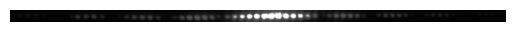

In [ ]:
# Cargar la imagen
image_path = "/content/Rejilla doble 3-1.jpg"
img = Image.open(image_path).convert('L')  # Escala de grises
img_array = np.array(img)

# Calcular un umbral para identificar la luz
threshold = np.percentile(img_array, 95)  # 5% más brillante
binary_mask = img_array > threshold

# Centro de masa (principalmente en y)
com_y, _ = center_of_mass(binary_mask)

# Definir altura del recorte
h = 60  # puedes ajustar esta altura (en píxeles)
half_h = h // 2

# Coordenadas del recorte
x_min = 0
x_max = img.width
y_min = max(0, int(com_y) - half_h)
y_max = min(img.height, int(com_y) + half_h)

# Recortar
cropped_img_6 = img.crop((x_min, y_min, x_max, y_max))

# Mostrar resultado
plt.imshow(cropped_img_6, cmap='gray')

plt.axis('off')
plt.show()

Centro en píxel: 1317
Primer pico en píxel: 1626
cm/píxel: 0.01996


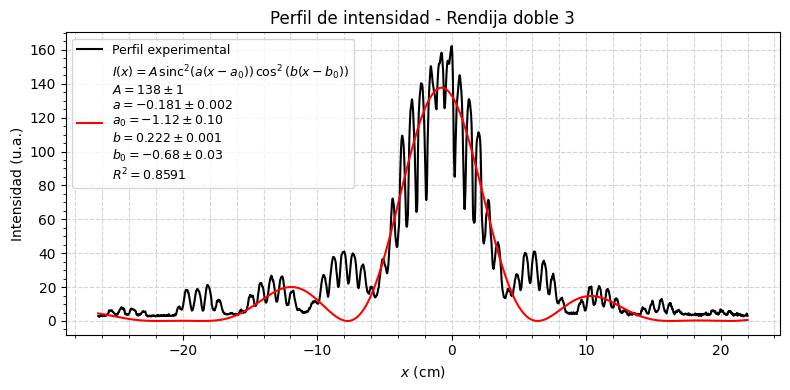

In [ ]:
# === Medir intensidad en x ===
cropped_array_6 = np.array(cropped_img_6)

# ===  Perfil de intensidad ===
intensity_profile = np.mean(cropped_array_6, axis=0)
x_pixels = np.arange(len(intensity_profile))

# === Encontrar máximo central y primer pico ===

# Encontrar máximo global (centro del patrón)
x_centro_px = np.argmax(intensity_profile)

# Para encontrar el primer pico a la derecha:
peaks, _ = find_peaks(intensity_profile, height=intensity_profile[x_centro_px]*0.2, distance=180)

# Filtrar picos a la derecha del centro
peaks_right = peaks[peaks > x_centro_px]
if len(peaks_right) == 0:
    raise ValueError("No se encontró un pico a la derecha del centro.")

x_pico_px = peaks_right[0]

# Factor de conversión
dist_cm = 6.169  # calibración
delta_px = x_pico_px - x_centro_px
cm_per_px = dist_cm / delta_px

# Vector de posiciones en cm centrado en 0
x_cm = (x_pixels - x_centro_px) * cm_per_px

print(f"Centro en píxel: {x_centro_px}")
print(f"Primer pico en píxel: {x_pico_px}")
print(f"cm/píxel: {cm_per_px:.5f}")

#x_cm
#intensity_profile

# Definir la función modelo
def double_slit(x, A, a, a0, b, b0):
    sinc_term = np.sinc(a * (x - a0) / np.pi)  # np.sinc(x) = sin(pi x)/(pi x)
    cos_term = np.cos(b * (x - b0))
    return A * sinc_term**2 * cos_term**2

# Estimación inicial de parámetros (ajústalos si conviene)
p0 = [np.max(intensity_profile), 1.0, 0.0, 1.0, 0.0]

# Ajuste de curva
popt, pcov = curve_fit(double_slit, x_cm, intensity_profile, p0=p0, maxfev=20000)
perr = np.sqrt(np.diag(pcov))

# Parámetros ajustados
A, a, a0, b, b0 = popt
dA, da, da0, db, db0 = perr

# Calcular R²
I_fit = double_slit(x_cm, *popt)
residuals = intensity_profile - I_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((intensity_profile - np.mean(intensity_profile))**2)
r_squared = 1 - (ss_res / ss_tot)

# Datos para la curva ajustada
x_fit = np.linspace(np.min(x_cm), np.max(x_cm), 1000)
I_fit_curve = double_slit(x_fit, *popt)

# Etiqueta con los parámetros
eq_label = (
    r"$I(x) = A\, \mathrm{sinc}^2(a(x-a_0))\, \cos^2(b(x-b_0))$" + "\n"
    + rf"$A = {A:.0f} \pm {dA:.0f}$" + "\n"
    + rf"$a = {a:.3f} \pm {da:.3f}$" + "\n"
    + rf"$a_0 = {a0:.2f} \pm {da0:.2f}$" + "\n"
    + rf"$b = {b:.3f} \pm {db:.3f}$" + "\n"
    + rf"$b_0 = {b0:.2f} \pm {db0:.2f}$" + "\n"
    + rf"$R^2 = {r_squared:.4f}$"
)

# Gráfica


plt.figure(figsize=(8,4))
plt.plot(x_cm, intensity_profile, label='Perfil experimental',color='black')
plt.plot(x_fit, I_fit_curve, '-', color='red', label=eq_label)
plt.xlabel("$x$ (cm)")
plt.ylabel("Intensidad (u.a.)")
plt.title("Perfil de intensidad - Rendija doble 3")
# Activar ticks secundarios en el eje X
plt.minorticks_on()
plt.legend(loc='upper left', fontsize=9)
plt.grid(axis='x', which='both', linestyle='--',color='lightgrey')
plt.grid(axis='y', which='major', linestyle='--',color='lightgrey')
plt.tight_layout()
plt.show()

In [ ]:
#ancho de la rendija (w) y separacion entre las rendijas
#Ajuste
z = 482.3 #cm +- 1cm
lam = 650e-7 #cm (longitud de onda del lasier rojo)

w_x_ajus = (z*lam*a/np.pi)*10 #mm

d_ajus = (z*lam*b/np.pi)*10

print("w_x_ajus =",w_ajus)
print("d_ajus =",d_ajus)


#Tracker
x_m = 4.086 #cm +- 0.001 cm(primer cero de irradiancia del patron de difracción)
x_n = 0.7 #cm +- 0.1 cm(separacion entre picos patron de interferencia)


w_x_trac = (lam*z/x_m)*10 #mm
d_trac = (lam*z/x_n)*10

print("w_x_trac =",w_trac)

print("d_trac =",d_trac)

w_x_ajus = 0.03057552678306405
d_ajus = 0.022183572942991593
w_x_trac = 0.9716777524999998
d_trac = 0.44784999999999997


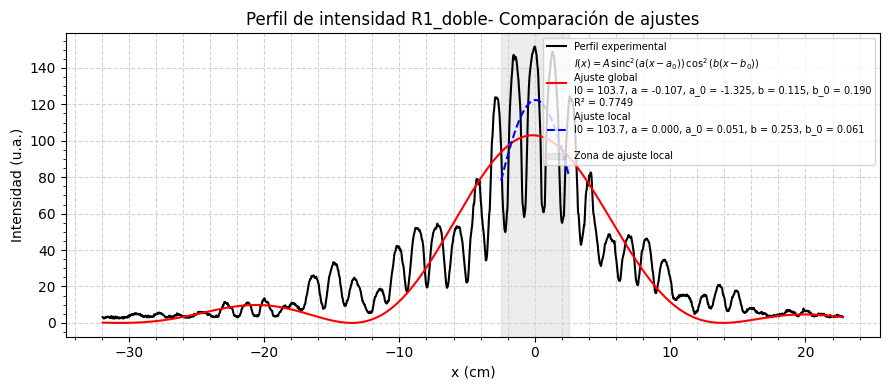